# Week 5 Lab: Data Preprocessing

After last week, we should now be comfortable with loading data into Python and then performing some basic summary statistics and/or constructing visualisations. Ideally, we want to be at the point where we can start to work with the data and, more importantly, understand what can and can't be done to the data. For example, we might be aware of missing values in the data, or data which has wildly varying numbers that may make it difficult compare attributes. We might be concerned about noise in the data, or presence of outliers. For all of this (and more), we need to 'fix up' our data so that we can obtain 'better' results. For the next two weeks that will be our overarching goal. This week we will focus mainly on data quality issues (missing values,  outliers etc.), aggregation, sampling, principal component analysis and discretization. Next week we will focus on hierarchical indexing, merging and reshaping of data, and tackle a few datasets to practice what we have learned so far.

As ever, this notebook was based on a variety of sources, such as _Introduction Data Mining_, McKinney's _Python for Data Analysis_ and notebooks of Jose Portilla. As such, these are excellent sources for more information. Should yet more sources be required, please do get in touch.

Recall, to execute the code, click on the corresponding cell and press the SHIFT-ENTER keys simultaneously.

## 5.1 Data Quality Issues

Poor data quality can have an adverse effect on data mining. Common data quality issues include noise, outliers, missing values, and duplicate data. This section presents examples of Python code to alleviate some of these data quality problems. We begin with an example dataset from the UCI machine learning repository containing information about breast cancer patients. We will first download the dataset using Pandas `read_csv()` function and display its first 5 data points. Note that we will later see another way to load this data set, but so that we have some practice with things seen last week, let's first go ahead and use `read_csv()`.

In [1]:
import pandas as pd
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']

data = data.drop(['Sample code'],axis=1)
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 699
Number of attributes = 10


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


### 5.1.1 Missing Values

It is not unusual for an object to be missing one or more attribute value. This could be because information was not collected, information has been lost or even in cases where some attributes are inapplicable to the data instances. This section presents examples on the different approaches for handling missing values. 

A good first step in understanding whether data is missing is to look at the documentation, assuming of course that such documenation is provided. In our example, the description of the data (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original) tells us that the missing values are encoded as '?' in the original data. Our first task is therefore to convert the missing values to `NaNs`. We can then count the number of missing values in each column of the data.


In [2]:
import numpy as np

data = data.replace('?',np.NaN)

print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

Number of instances = 699
Number of attributes = 10
Number of missing values:
	Clump Thickness: 0
	Uniformity of Cell Size: 0
	Uniformity of Cell Shape: 0
	Marginal Adhesion: 0
	Single Epithelial Cell Size: 0
	Bare Nuclei: 16
	Bland Chromatin: 0
	Normal Nucleoli: 0
	Mitoses: 0
	Class: 0


Observe that only the 'Bare Nuclei' column contains missing values. This is a term used for nuclei not surrounded by cytoplasm (the rest of the cell) and are typically seen in benign tumors. As such, it might not be sensible to simply remove data points which have missing values here. Instead, we will replace the missing values in the 'Bare Nuclei' column by the median value of that column. In the following, the values before and after replacement are shown for a subset of the data points.

In [3]:
data2 = data['Bare Nuclei']

print('Before replacing missing values:')
print(data2[20:25])
data2 = data2.fillna(data2.median())

print('\nAfter replacing missing values:')
print(data2[20:25])

Before replacing missing values:
20     10
21      7
22      1
23    NaN
24      1
Name: Bare Nuclei, dtype: object

After replacing missing values:
20     10
21      7
22      1
23    1.0
24      1
Name: Bare Nuclei, dtype: object


If we had multiple columns with missing data, we can also use a different fill value for each column by calling `fillna` with a dict, e.g. `data.dillna({2:0, 4:1})` would replace the third column missing values with 0, and the fifth column missing values with 1.

As hinted above, instead of replacing missing values, another common approach is to discard the data points that contain missing values. This can be easily accomplished by applying the dropna() function to the data frame.

In [4]:
print('Number of rows in original data = %d' % (data.shape[0]))

data2 = data.dropna()
print('Number of rows after discarding missing values = %d' % (data2.shape[0]))

Number of rows in original data = 699
Number of rows after discarding missing values = 683


### 5.1.2 Outliers

Outliers are data instances with characteristics that are considerably different from the rest of the dataset. In the example code below, we will draw a boxplot to identify the columns in the table that contain outliers. Note that the values in all columns (except for 'Bare Nuclei') are originally stored as 'int64' whereas the values in the 'Bare Nuclei' column are stored as string objects (since the column initially contains strings such as '?' for representing missing values). Thus, we must  convert the column into numeric values first before creating the boxplot. Otherwise, the column will not be displayed when drawing the boxplot.

<AxesSubplot:>

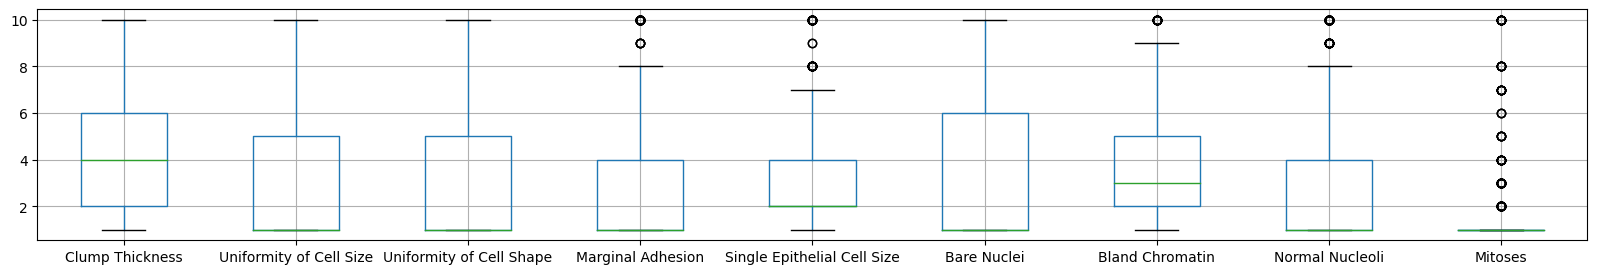

In [5]:
%matplotlib inline

data2 = data.drop(['Class'],axis=1)
data2['Bare Nuclei'] = pd.to_numeric(data2['Bare Nuclei'])
data2.boxplot(figsize=(20,3))

The boxplots suggest that only 5 of the columns (Marginal Adhesion, Single Epithetial Cell Size, Bland Cromatin, Normal Nucleoli, and Mitoses) contain abnormally high values.

To be more specific, we can also find values in a given column that exceed a certain value. For example, we can look at those values in the Mitoses column which exceeds a value of 6.

In [6]:
mit=data2['Mitoses']

mit[mit>6]

53      7
65     10
68      8
71     10
84      7
85     10
98     10
104     8
105     7
117     8
149     7
163     7
167    10
173     7
187    10
236    10
238    10
268     8
279     8
286    10
302    10
357     8
360    10
366     7
400     8
482    10
506     7
612    10
648    10
680     7
689     8
Name: Mitoses, dtype: int64

To discard the outliers, we can compute the Z-score for each attribute and remove those instances containing attributes with abnormally high or low Z-score (e.g., if $Z > 3$ or $Z \leq -3$). 

The following code shows the results of standardizing the columns of the data. Note that missing values (NaN) are not affected by the standardization process.

In [7]:
Z = (data2-data2.mean())/data2.std()
Z[20:25]

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
20,0.917080,-0.044070,-0.406284,2.519152,0.805662,1.771569,0.640688,0.371049,1.405526
21,1.982519,0.611354,0.603167,0.067638,1.257272,0.948266,1.460910,2.335921,-0.343666
22,-0.503505,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.589645,-0.611387,-0.343666
23,1.272227,0.283642,0.603167,-0.632794,-0.549168,NaN,1.460910,0.043570,-0.343666
24,-1.213798,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.179534,-0.611387,-0.343666


In [8]:
Z[65:70]

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
65,1.982519,0.283642,-0.406284,-0.632794,-0.097558,-0.423907,0.230577,0.043570,4.903909
66,-0.148359,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.179534,-0.611387,-0.343666
67,0.206788,-0.044070,0.266684,-0.632794,2.160492,1.771569,0.230577,2.008442,-0.343666
68,1.272227,-0.044070,1.612618,0.067638,0.354052,1.497134,1.871021,2.008442,3.737781
69,-1.213798,-0.699494,-0.742767,-0.632794,-0.549168,-0.698341,-0.179534,-0.283909,-0.343666


The following code shows the results of discarding columns with $Z > 3$ or $Z \leq -3$.

In [9]:
print('Number of rows before discarding outliers = %d' % (Z.shape[0]))

Z2 = Z.loc[((Z > -3).sum(axis=1)==9) & ((Z <= 3).sum(axis=1)==9),:]
print('Number of rows after discarding outliers = %d' % (Z2.shape[0]))

Number of rows before discarding outliers = 699
Number of rows after discarding outliers = 632


### 5.1.3 Duplicate Data

Some datasets, especially those obtained by merging multiple data sources, may contain duplicates or near duplicate instances. The term deduplication is often used to refer to the process of dealing with duplicate data issues.

In the following, we first check for duplicate instances in the breast cancer dataset.

In [10]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
data.loc[[11,28]]

Number of duplicate rows = 236


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
11,2,1,1,1,2,1,2,1,1,2
28,2,1,1,1,2,1,2,1,1,2


The `duplicated()` function will return a Boolean array that indicates whether each row is a duplicate of a previous row in the table. The results suggest there are 236 duplicate rows in the breast cancer dataset. For example, the instance with row index 11 has identical attribute values as the instance with row index 28. Although such duplicate rows may correspond to samples for different individuals, in this hypothetical example, we assume that the duplicates are samples taken from the same individual and illustrate below how to remove the duplicated rows.

In [11]:
print('Number of rows before discarding duplicates = %d' % (data.shape[0]))
data2 = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data2.shape[0]))

Number of rows before discarding duplicates = 699
Number of rows after discarding duplicates = 463


### 5.1.4 Data Quality Exercises

1. Create a DataFrame which has three columns and three rows. Make sure one row and one column have no missing values, one row and one column has one missing value, and one row and one column has two missing values.
2. For the DataFrame constructed in part (1), drop all rows with a missing value. Then go back and instead remove all columns which have a missing value. Finally, go back and instead remove only rows which have more than one missing value.
3. For the DataFrame constructed in aprt (1), fill all missing values with a fixed new value. Then go back and instead replace the missing value in the column with just one missing value with the mean of the other values in that column.
4. Use `from sklearn.datasets import load_diabetes` to load the Diabetes dataset that comes preloaded in the sklearn library. Output the first five rows and then use a box plot to visualise outliers using bmi.
5. For the Diabetes dataset, create a scatterplot of bmi against bp and find outliers.
6. For the Diabetes dataset, use Z-score normalisation (see notes) on age to find a quantitative measure of how far each data point is from the mean. Use this to find outliers. Then create a threshold value (which value should you take?) and output those values which exceed this threshold.
7. Finally, use IQR to find outliers on bmi. You will need to think carefully on how you define a 'normal' range.

## 5.2 Aggregation

Data aggregation is a preprocessing task where the values of two or more objects are combined into a single object. The motivation for aggregation includes (1) reducing the size of data to be processed, (2) changing the granularity of analysis (from fine-scale to coarser-scale), and (3) improving the stability of the data.

In the example below, we will use the daily precipitation time series data for a weather station located at Detroit Metro Airport. The raw data was obtained from the Climate Data Online website (https://www.ncdc.noaa.gov/cdo-web/datasets). The daily precipitation time series will be compared against its monthly values.

The code below will load the precipitation time series data and draw a line plot of its daily time series.

Text(0.5, 1.0, 'Daily Precipitation (variance = 0.0530)')

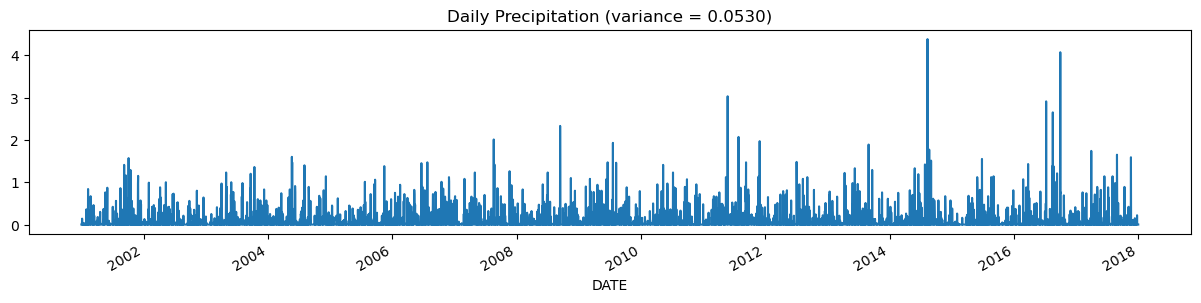

In [12]:
daily = pd.read_csv('DTW_prec.csv', header='infer')
daily.index = pd.to_datetime(daily['DATE'])
daily = daily['PRCP']
ax = daily.plot(kind='line',figsize=(15,3))
ax.set_title('Daily Precipitation (variance = %.4f)' % (daily.var()))

Observe that the daily time series appear to be quite chaotic and varies significantly from one time step to another. The time series can be grouped and aggregated by month to obtain the total monthly precipitation values. The resulting time series appears to vary more smoothly compared to the daily time series.

Text(0.5, 1.0, 'Monthly Precipitation (variance = 2.4241)')

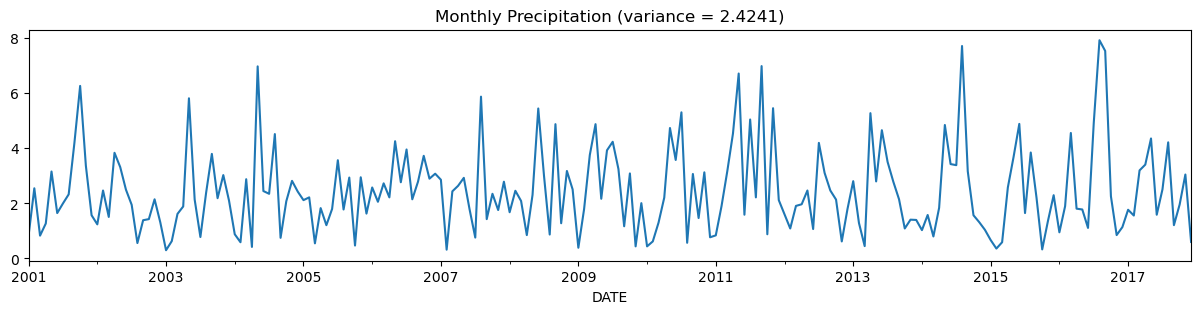

In [13]:
monthly = daily.groupby(pd.Grouper(freq='M')).sum()
ax = monthly.plot(kind='line',figsize=(15,3))
ax.set_title('Monthly Precipitation (variance = %.4f)' % (monthly.var()))

In the example below, the daily precipitation time series are grouped and aggregated by year to obtain the annual precipitation values. 

Text(0.5, 1.0, 'Annual Precipitation (variance = 23.6997)')

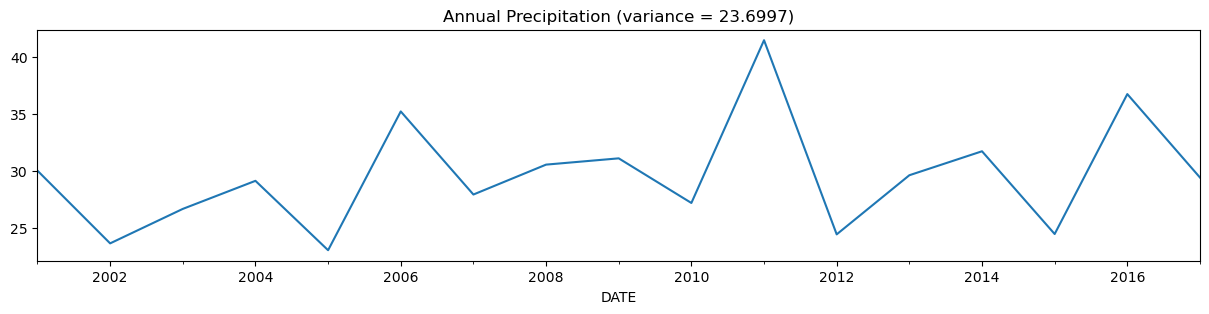

In [14]:
annual = daily.groupby(pd.Grouper(freq='Y')).sum()
ax = annual.plot(kind='line',figsize=(15,3))
ax.set_title('Annual Precipitation (variance = %.4f)' % (annual.var()))

Note that the `.groupby()` method should familiar to us from the SQL part of the course. All it does is group together rows based off of a column and then perform an aggregate function on them. So, if we have a table with an ID column and a value column, then we lump together all those values associated to the first ID, then all those associated to the second ID, and so on. We then perform whatever aggregation we want to these values (e.g. work out the mean, median etc.)

## 5.2.1 Aggregation Exercises

Consider the following DataFrame.

In [15]:
data = {'Company':['GOOG','GOOG','MSFT','MSFT','AAPL','AAPL'],
       'Person':['Sam','Rincewind','Margrat','Eskarina','Horace','Mort'],
       'Sales':[200,120,340,124,243,350]}

df = pd.DataFrame(data)

df

,Company,Person,Sales
0,GOOG,Sam,200
1,GOOG,Rincewind,120
2,MSFT,Margrat,340
3,MSFT,Eskarina,124
4,AAPL,Horace,243
5,AAPL,Mort,350


The following exercises should now hopefully be straightforward and are simply meant to give you practice of working with `.groupby()` and other aggregate methods.

1. First group based off of Company. Then aggregate by:
    - mean,
    - standard deviation,
    - minimum value,
    - maximum value,
    - count.
2. Finally create a DataFrame which outputs several standard statistical measures for each company.

## 5.3 Sampling

Sampling is an approach commonly used to facilitate (1) data reduction for exploratory data analysis and scaling up algorithms to big data applications and (2) quantifying uncertainties due to varying data distributions. There are various methods available for data sampling, such as sampling without replacement, where each selected instance is removed from the dataset, and sampling with replacement, where each selected instance is not removed, thus allowing it to be selected more than once in the sample.

In the example below, we will apply sampling with replacement and without replacement to the breast cancer dataset obtained from the UCI machine learning repository.

We initially display the first five records of the table.

In [16]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']

data = data.drop(['Sample code'],axis=1)

data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In the following code, a sample of size 3 is randomly selected (without replacement) from the original data.

In [17]:
sample = data.sample(n=3)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
166,5,6,7,8,8,10,3,10,3,4
82,5,2,1,1,2,1,3,1,1,2
261,5,10,10,6,10,10,10,6,5,4


In the next example, we randomly select 1% of the data (without replacement) and display the selected samples. The random_state argument of the function specifies the seed value of the random number generator.

In [18]:
sample = data.sample(frac=0.01, random_state=1)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
584,5,1,1,6,3,1,1,1,1,2
417,1,1,1,1,2,1,2,1,1,2
606,4,1,1,2,2,1,1,1,1,2
349,4,2,3,5,3,8,7,6,1,4
134,3,1,1,1,3,1,2,1,1,2
502,4,1,1,2,2,1,2,1,1,2
117,4,5,5,10,4,10,7,5,8,4


Finally, we perform a sampling with replacement to create a sample whose size is equal to 1% of the entire data. You should be able to observe duplicate instances in the sample by increasing the sample size.

In [19]:
sample = data.sample(frac=0.01, replace=True, random_state=1)
sample

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
37,6,2,1,1,1,1,7,1,1,2
235,3,1,4,1,2,?,3,1,1,2
72,1,3,3,2,2,1,7,2,1,2
645,3,1,1,1,2,1,2,1,1,2
144,2,1,1,1,2,1,2,1,1,2
129,1,1,1,1,10,1,1,1,1,2
583,3,1,1,1,2,1,1,1,1,2


## 5.4 Discretization

Discretization is a data preprocessing step that is often used to transform a continuous-valued attribute to a categorical attribute. The example below illustrates two simple but widely-used unsupervised discretization methods (equal width and equal depth) applied to the 'Clump Thickness' attribute of the breast cancer dataset.

First, we plot a histogram that shows the distribution of the attribute values. The `value_counts()` function can also be applied to count the frequency of each attribute value.

5     130
3     108
6      34
4      80
8      46
1     145
2      50
7      23
10     69
9      14
Name: Clump Thickness, dtype: int64

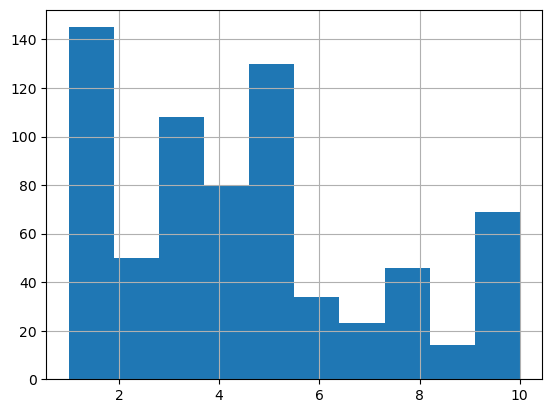

In [20]:
data['Clump Thickness'].hist(bins=10)
data['Clump Thickness'].value_counts(sort=False)

For the equal width method, we can apply the `cut()` function to discretize the attribute into 4 bins of similar interval widths. The `value_counts()` function can be used to determine the number of instances in each bin.

In [21]:
bins = pd.cut(data['Clump Thickness'],4)
bins.value_counts(sort=False)

(0.991, 3.25]    303
(3.25, 5.5]      210
(5.5, 7.75]       57
(7.75, 10.0]     129
Name: Clump Thickness, dtype: int64

For the equal frequency method, the `qcut()` function can be used to partition the values into 4 bins such that each bin has nearly the same number of instances.

In [22]:
bins = pd.qcut(data['Clump Thickness'],4)
bins.value_counts(sort=False)

(0.999, 2.0]    195
(2.0, 4.0]      188
(4.0, 6.0]      164
(6.0, 10.0]     152
Name: Clump Thickness, dtype: int64

## 5.5 Principal Component Analysis

Principal component analysis (PCA) is a classical unsupervised method for reducing the number of attributes in the data by projecting the data from its original high-dimensional space into a lower-dimensional space. The new attributes (also known as components) created by PCA have the following properties: (1) they are linear combinations of the original attributes, (2) they are orthogonal (perpendicular) to each other, and (3) they capture the maximum amount of variation in the data. We can understand this by contrasting with regression. Recall, regression determines a line (or higher dimensional analogue) of best fit to a data set. In contrast, PCA determines several orthogonal lines of best fit to the data set. The first orthogonal line contains the majority of the variance, then the second contains the second largest amount of variance and so on. In this way, we can reduce the number of attributes used by limiting how many orthogonal lines we use. How many we use depends on how much variance is 'explained' by the first line, and so on. As might be expected with this (very) handwavy description of PCA, a big challenge is in the interpretation of components.

Once again we will turn to a cancer data set to demonstrate how PCA is used. This time, we will load it from `sklearn.datasets` demonstrating another dataset that comes preloaded with this library (recall, above we used it to load the Diabetes data set).

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

In [24]:
# Observe the dictionary keys for this data set
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

Note that we have a description key, a target key, frame key etc. The description key is particularly important for now as it will summarise the data for us. As such, let's see that.

In [25]:
print(cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [26]:
# Now let's load the data, much as before
df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Note that if we instead called `cancer['target']` then we would get a bunch of 1s and 0s signifying malignant/benign. If we actually wanted to predict this, we would need to run some other algorithms (which we will see in later labs) but the idea is that we would first use PCA to get a handle on what is important in this task

As it is difficult to visualise high dimensional data (this example has 30 dimensions), we can use PCA to find the first two (or however many) principal components, and visualise the data in this new, two-dimensional space, with a single scatter-plot. This will enable us to determine the most important components which explain the most variance in the data. Before we do this though, we'll need to scale our data so that each feature has a single unit variance.

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)

StandardScaler()

In [28]:
scaled_data = scaler.transform(df)

PCA with Scikit Learn uses a very similar process to other preprocessing functions that come with SciKit Learn. We instantiate a PCA object, find the principal components using the fit method, then apply the rotation and dimensionality reduction by calling `transform()`. We can also specify how many components we want to keep when creating the PCA object.

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [30]:
pca.fit(scaled_data)

PCA(n_components=2)

Now we can transform this data to its first two principal components.

In [31]:
x_pca = pca.transform(scaled_data)

In [32]:
scaled_data.shape

(569, 30)

In [33]:
x_pca.shape

(569, 2)

Notice how we have reduced 30 dimensions to just 2. We can now plot these to gain a meaningful visualisation, adding in a colouration for malignant/benign.

Text(0, 0.5, 'Second Principal Component')

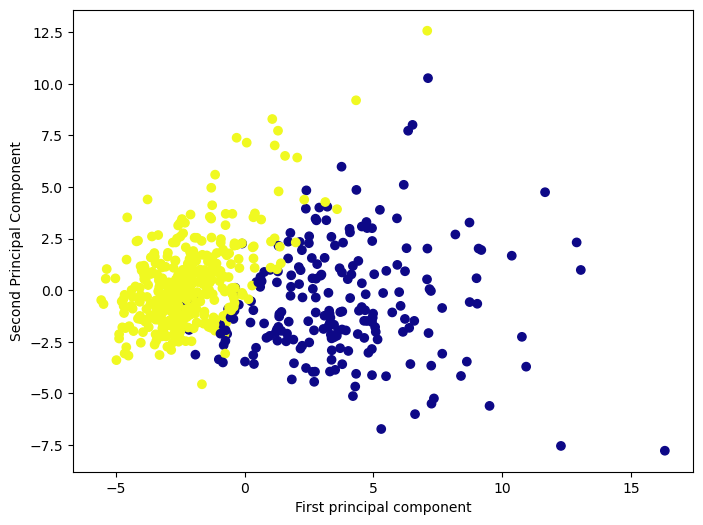

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=cancer['target'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

It is now clear that by using these two components we can easily separate these two classes. In a sense, we have 'compressed' the information from 30 dimensions down to 2 but kept the necessary information that we can still separate the data into two clusters.

Unfortunately, there is always a cost to be paid and dimensionality reduction is no different. In the case of PCA, it comes at the cost of being able to easily understand what these components represent. Recall, the components correspond to _combinations_ of the original features. As a starting point, let us look at the components themselves which are stored as an attribute of the fitted PCA object.

In [35]:
pca.components_

array([[ 0.21890244,  0.10372458,  0.22753729,  0.22099499,  0.14258969,
         0.23928535,  0.25840048,  0.26085376,  0.13816696,  0.06436335,
         0.20597878,  0.01742803,  0.21132592,  0.20286964,  0.01453145,
         0.17039345,  0.15358979,  0.1834174 ,  0.04249842,  0.10256832,
         0.22799663,  0.10446933,  0.23663968,  0.22487053,  0.12795256,
         0.21009588,  0.22876753,  0.25088597,  0.12290456,  0.13178394],
       [-0.23385713, -0.05970609, -0.21518136, -0.23107671,  0.18611302,
         0.15189161,  0.06016536, -0.0347675 ,  0.19034877,  0.36657547,
        -0.10555215,  0.08997968, -0.08945723, -0.15229263,  0.20443045,
         0.2327159 ,  0.19720728,  0.13032156,  0.183848  ,  0.28009203,
        -0.21986638, -0.0454673 , -0.19987843, -0.21935186,  0.17230435,
         0.14359317,  0.09796411, -0.00825724,  0.14188335,  0.27533947]])

In this numpy matrix array, each row represents a principal component, and each column relates back to the original features. we can visualize this relationship with a heatmap:

In [36]:
df_comp = pd.DataFrame(pca.components_,columns=cancer['feature_names'])
df_comp

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.218902,0.103725,0.227537,0.220995,0.142590,0.239285,0.258400,0.260854,0.138167,0.064363,...,0.227997,0.104469,0.236640,0.224871,0.127953,0.210096,0.228768,0.250886,0.122905,0.131784
1,-0.233857,-0.059706,-0.215181,-0.231077,0.186113,0.151892,0.060165,-0.034768,0.190349,0.366575,...,-0.219866,-0.045467,-0.199878,-0.219352,0.172304,0.143593,0.097964,-0.008257,0.141883,0.275339


<AxesSubplot:>

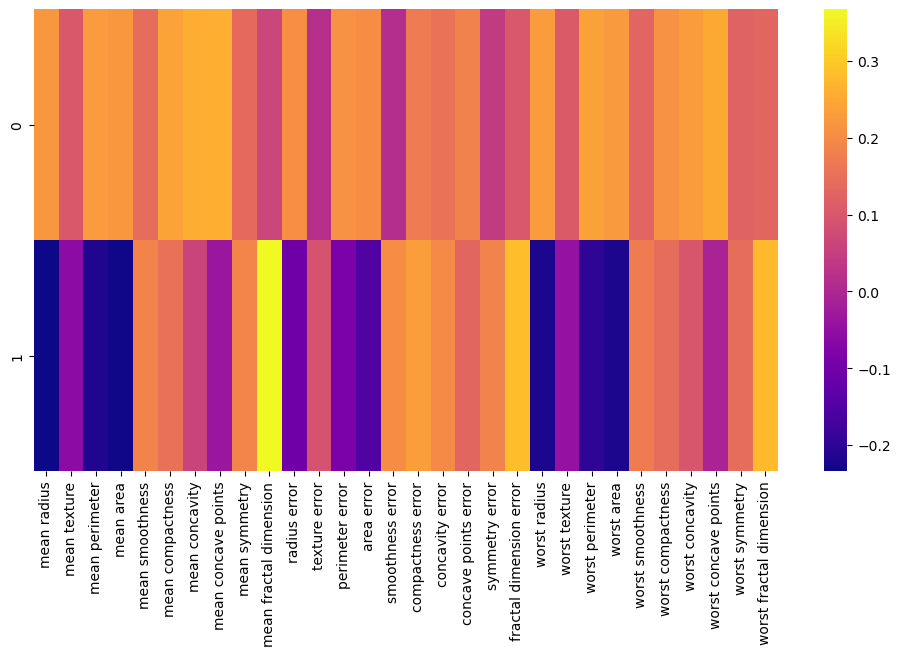

In [37]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

This heatmap and the color bar basically represent the correlation between the various feature and the principal component itself. So, each pricipal component is represented by a row and the higher/hotter the colour, the more correlated it is to a given feature.

That's all we have to say about PCA at this point, though keep in mind that the purpose here is to 'compress' our data to aid our future algorithms. So, say we want to run some regression or classification algorithm, then we would feed in `x_pca` instead of the original DataFrame. Not only would this sometimes give us information about what algorithm(s) to use (for example, the above picture does suggest Support Vector Machines might be useful), but it also helps with the algorithm(s) itself, since we are feeding it fewer features.

## 5.5.1 Principal Component Analysis Exercises

On Canvas you should find 16 RGB files, each of which has a size of 111 x 111 pixels. Perform PCA to this image dataset by first reading each image file and converting the RGB into a 111 x 111 x 3 (=36963) feature values, thereby creating a data matrix of size 16 x 36963. Interpret your results.

## 5.6 Summary

After completing the above, we should now be able to complete basic data preprocessing, including data cleaning (to handle missing values and remove outliers as well as duplicate data), aggregation, sampling, discretization, and dimensionality reduction using principal component analysis. For more information, read Chapters 7 and 10 of McKinney.

**<font color='blue'>References:</font>**

1. Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

2. Mangasarian, O.L. and Wolberg, W. H. (1990). "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, pp 1 & 18.

3. Wolberg, W.H. and Mangasarian, O.L. (1990). "Multisurface method of pattern separation for medical diagnosis applied to breast cytology", Proceedings of the National Academy of Sciences, U.S.A., Volume 87, pp 9193-9196. 

4. Climate Data Online [https://www.ncdc.noaa.gov/cdo-web/]. 